In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [49]:
train_data = pd.read_csv('eda_simple_classification/network_data_mod.csv')
test_data = pd.read_csv('eda_simple_classification/network_data_mod_test.csv')

frames = [train_data, test_data]

dataframe  = pd.concat(frames)
raw_data = dataframe.values
dataframe.head()


,Unnamed: 0,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1
1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1
2,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1
4,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1


In [50]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [51]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [52]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

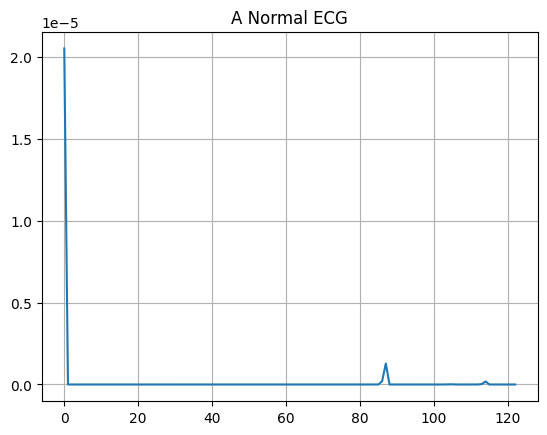

In [59]:
plt.grid()
plt.plot(np.arange(123), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

In [60]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(123, activation="sigmoid")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [61]:
autoencoder.compile(optimizer='adam', loss='mae')

In [62]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          validation_data=(normal_test_data, normal_test_data),
          shuffle=True)

Epoch 1/20
1925/1925 [==============================] - 6s 2ms/step - loss: 0.0172 - val_loss: 4.7269e-06
Epoch 2/20
1925/1925 [==============================] - 3s 2ms/step - loss: 2.3017e-06 - val_loss: 1.0875e-06
Epoch 3/20
1925/1925 [==============================] - 3s 2ms/step - loss: 7.2643e-07 - val_loss: 4.8727e-07
Epoch 4/20
1925/1925 [==============================] - 3s 2ms/step - loss: 4.1697e-07 - val_loss: 3.4499e-07
Epoch 5/20
1925/1925 [==============================] - 3s 2ms/step - loss: 3.3594e-07 - val_loss: 3.0325e-07
Epoch 6/20
1925/1925 [==============================] - 3s 2ms/step - loss: 3.1123e-07 - val_loss: 2.8974e-07
Epoch 7/20
1925/1925 [==============================] - 3s 2ms/step - loss: 3.0342e-07 - val_loss: 2.8568e-07
Epoch 8/20
1925/1925 [==============================] - 3s 2ms/step - loss: 3.0079e-07 - val_loss: 2.8296e-07
Epoch 9/20
1925/1925 [==============================] - 3s 2ms/step - loss: 2.9928e-07 - val_loss: 2.8612e-07
Epoch 10/20
19

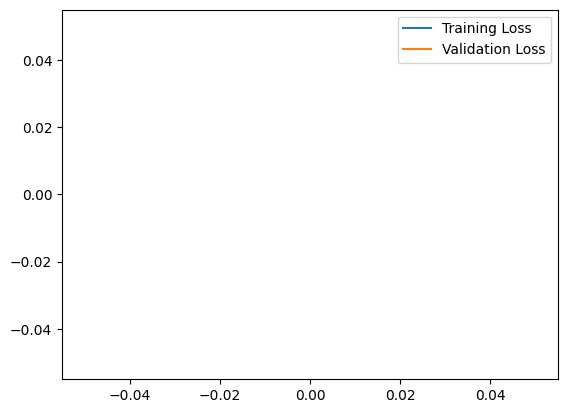

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

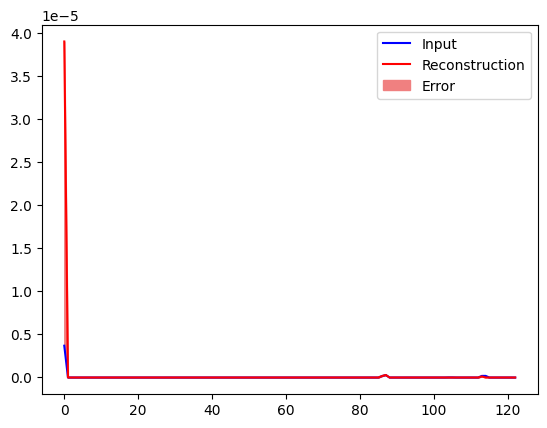

In [64]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(123), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

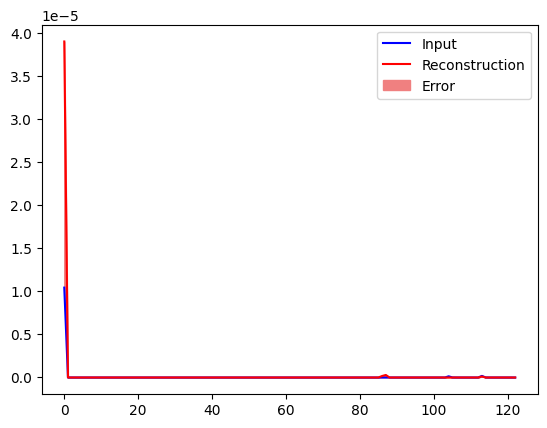

In [66]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(123), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

1925/1925 [==============================] - 2s 1ms/step


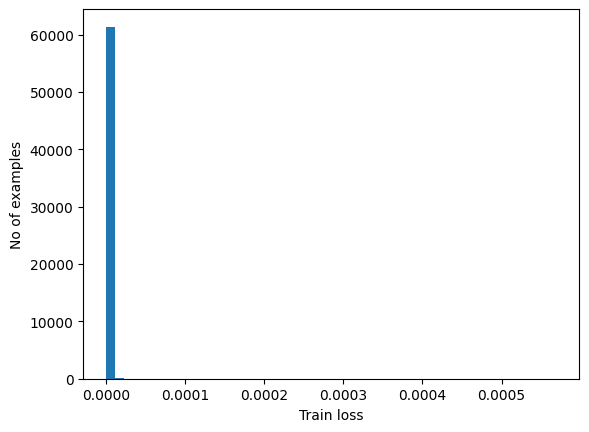

In [67]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [70]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  2.9860698e-06


In [71]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [73]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.5187516832749798
Precision = 0.5197555045251925
Recall = 0.9952150016165535
